# Analysis of Reddit comments based on TF-IDF using PySpark 

In [1]:
import numpy as np 
import pandas as pd 
import time         
import matplotlib.pyplot as plt

In [ ]:
from pyspark import SparkContext
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.window import *

In [ ]:
# Measures the execution time 
start_time = time.process_time()

In [ ]:
# Sets random seed for notebook reproducability
rnd_seed=23
np.random.seed=rnd_seed
np.random.set_state=rnd_seed

In [ ]:
spark = SparkSession.builder\
        .master(f'spark://192.168.2.41:7077') \
        .appName('group-9_project')\
        .config('spark.dynamicAllocation.enabled', True)\
        .config('spark.dynamicAllocation.shuffleTracking.enabled',True)\
        .config('spark.shuffle.service.enabled', False)\
        .config('spark.dynamicAllocation.executorIdleTimeout','30s')\
        .config('spark.cores.max', 2)\
        .getOrCreate()

sql_context = SQLContext(spark.sparkContext)

In [ ]:
# Loads the Reddit dataset containing comments as JSON documents from HDFS into a DataFrame 
# and stores it in cache memory to increase speed.
comments = sql_context.read.json('hdfs://192.168.2.245:9000/group-9/RC_2005-12').cache()

## Data Exploration

In [ ]:
# Prints the schema of the Reddit comments. 
comments.printSchema()

root
 |-- author: string (nullable = true)
 |-- author_flair_css_class: string (nullable = true)
 |-- author_flair_text: string (nullable = true)
 |-- body: string (nullable = true)
 |-- controversiality: long (nullable = true)
 |-- created_utc: long (nullable = true)
 |-- distinguished: string (nullable = true)
 |-- edited: boolean (nullable = true)
 |-- gilded: long (nullable = true)
 |-- id: string (nullable = true)
 |-- link_id: string (nullable = true)
 |-- parent_id: string (nullable = true)
 |-- retrieved_on: long (nullable = true)
 |-- score: long (nullable = true)
 |-- stickied: boolean (nullable = true)
 |-- subreddit: string (nullable = true)
 |-- subreddit_id: string (nullable = true)
 |-- ups: long (nullable = true)



In [ ]:
# Removes comments without an author. 
comments = comments.filter(col('author') != '[deleted]')

In [ ]:
# Extracts the documents (comment bodies) of the Reddit comments. 
comment_text_score = comments.select(col('body').alias('Comment_Text'), col('score').alias('Score'))

In [ ]:
# Prints the documents in the document corpus.
comment_text_score.show()

+--------------------+-----+
|        Comment_Text|Score|
+--------------------+-----+
|A look at Vietnam...|    2|
|The site states "...|    1|
|Saft is by far th...|    1|
|How to take panor...|    1|
|I donât know wh...|    1|
|LinkIt by Marc, a...|    1|
|Making websites r...|    1|
|On the bright sid...|    1|
|Like a lot of peo...|    8|
|It's a New York T...|    3|
|[Here's the copy ...|   12|
|The best thing ab...|    5|
|You can rank the ...|    7|
|just testing this...|  -21|
|               ye ye|    0|
|_We didn't tortur...|    1|
|Interesting artic...|    1|
|reddit got a "run...|    1|
|this is wonderful...|   -9|
|cool.  i love a g...|   -9|
+--------------------+-----+
only showing top 20 rows



## Preprocessing

In [ ]:
# Pre-processes each document in the document corpus. 
def preprocess(documents):
    
    # 1. Filters out deleted/removed documents
    # 2. Removes URLs in the documents.
    # 3. Converts the documents into lower case.
    # 4. Removes non-alphabetic characters from the documents.
    # 5. Trims the documents (removes leading and trailing spaces) 
    # 6. Removes empty documents 
    # 7. Tokenizes the documents (splits on whitespace)
    
    return documents.withColumn('Comment_Text', regexp_replace(col('Comment_Text'), 'http:\S+|www\.\S+', '')) \
                    .withColumn('Comment_Text', lower(col('Comment_Text'))) \
                    .withColumn('Comment_Text', regexp_replace(col('Comment_Text'), "[^a-z'\s]", ' ')) \
                    .withColumn('Comment_Text', regexp_replace(col('Comment_Text'), "^\s*|\s*$", '')) \
                    .filter(length(col('Comment_Text')) > 0) \
                    .withColumn('Comment_Text', split(col('Comment_Text'), '\s+')) 

In [ ]:
# Preprocesses each document in the document corpus.
comment_text_score = preprocess(comment_text_score)
comment_text_score.show()

+--------------------+-----+
|        Comment_Text|Score|
+--------------------+-----+
|[a, look, at, vie...|    2|
|[the, site, state...|    1|
|[saft, is, by, fa...|    1|
|[how, to, take, p...|    1|
|[i, don, t, know,...|    1|
|[linkit, by, marc...|    1|
|[making, websites...|    1|
|[on, the, bright,...|    1|
|[like, a, lot, of...|    8|
|[it's, a, new, yo...|    3|
|[here's, the, cop...|   12|
|[the, best, thing...|    5|
|[you, can, rank, ...|    7|
|[just, testing, t...|  -21|
|            [ye, ye]|    0|
|[we, didn't, tort...|    1|
|[interesting, art...|    1|
|[reddit, got, a, ...|    1|
|[this, is, wonder...|   -9|
|[cool, i, love, a...|   -9|
+--------------------+-----+
only showing top 20 rows



## Data Visualization

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Converts to a Pandas dataframe. 
comment_text_score_pd = comment_text_score.groupBy('Score').agg(count('Comment_Text').alias('Count')).sort('Score').toPandas()

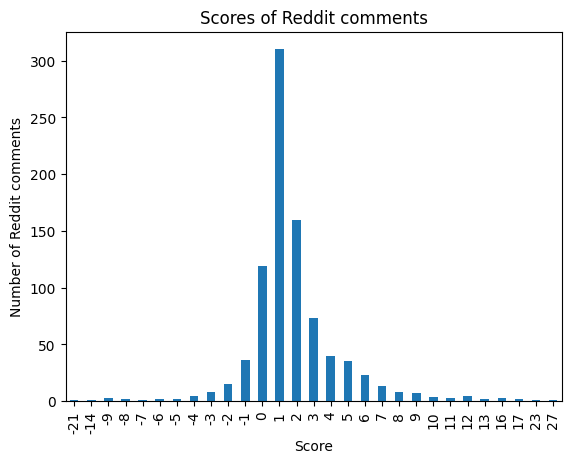

In [ ]:
# Plots the scores of all the Reddit comments.
comment_text_score_pd.plot.bar(x='Score', y='Count', legend=None)
plt.title('Scores of Reddit comments')
plt.ylabel('Number of Reddit comments')
plt.show()

We can see from the figure that most of the Reddit comments has a score around 1. 

## Feature Engineering/Extraction

Use HashingTF() and IDF() to put features into a feature vector column. 

In [ ]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import StringIndexer
from pyspark.ml.regression import LinearRegression
from pyspark.mllib.evaluation import RegressionMetrics
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.feature import HashingTF, IDF, StopWordsRemover
from pyspark.ml.evaluation import RegressionEvaluator

In [ ]:
stop_words_remover = StopWordsRemover(inputCol="Comment_Text", outputCol="Filtered_Comment_Text")
comments_filtered = stop_words_remover.transform(comment_text_score)

hashing_tf = HashingTF(inputCol="Filtered_Comment_Text", outputCol="Raw_Features", numFeatures=20)
tf = hashing_tf.transform(comments_filtered)

idf = IDF(inputCol="Raw_Features", outputCol="Features")
idf_model = idf.fit(tf)
tfidf = idf_model.transform(tf)

tfidf.show()

+--------------------+-----+---------------------+--------------------+--------------------+
|        Comment_Text|Score|Filtered_Comment_Text|        Raw_Features|            Features|
+--------------------+-----+---------------------+--------------------+--------------------+
|[a, look, at, vie...|    2| [look, vietnam, m...|(20,[1,10,12,13,1...|(20,[1,10,12,13,1...|
|[the, site, state...|    1| [site, states, us...|(20,[0,1,3,4,5,6,...|(20,[0,1,3,4,5,6,...|
|[saft, is, by, fa...|    1| [saft, far, best,...|(20,[0,3,6,13,18,...|(20,[0,3,6,13,18,...|
|[how, to, take, p...|    1| [take, panoramic,...|(20,[1,2,15,16],[...|(20,[1,2,15,16],[...|
|[i, don, t, know,...|    1| [know, came, stuf...|(20,[0,2,4,5,7,9,...|(20,[0,2,4,5,7,9,...|
|[linkit, by, marc...|    1| [linkit, marc, al...|(20,[2,4,5,14,16]...|(20,[2,4,5,14,16]...|
|[making, websites...|    1| [making, websites...|(20,[0,1,2,4,6,12...|(20,[0,1,2,4,6,12...|
|[on, the, bright,...|    1| [bright, side, de...|(20,[0,1,6,7,10,1...

The result displays that the features have transformed into a Dense Vector.

We have generated enough information post preprocessing our data to feed it to the model. 

## Building A Machine Learning Model With Spark ML
As we have finished the preprocessing of our data, now we build our Linear Regression model. We first need to split the data into train and test sets, using the randomSplit() method:

In [ ]:
# Split the data into train,test and Validation sets
train_data, test_data = tfidf.randomSplit([.7,.3], seed=rnd_seed)

In [ ]:
# Initialize `lr`
lr = (LinearRegression(featuresCol='Features', labelCol='Score', predictionCol='Predicted_Score', 
                               maxIter=100, regParam=0.3, elasticNetParam=0.8, standardization=False))

In [ ]:
# Fit the data to the model
linearModel = lr.fit(train_data)

### Generate Predictions

In [ ]:
# Generate predictions
predictions = linearModel.transform(test_data)
# Select the columns and store in a variable
pred_data= predictions.select("Predicted_Score", "Score").show()

+------------------+-----+
|   Predicted_Score|Score|
+------------------+-----+
| 3.422759320314616|    0|
|2.1918098441433655|    2|
|1.6126884057850877|    1|
|1.3453529065778338|    2|
|1.5387904911055432|    2|
|1.5387904911055432|    1|
|1.8788325897674913|    1|
|1.5387904911055432|    5|
|1.7088115404365172|    3|
| 2.680839087389253|    5|
|1.7322280756332527|    1|
| 1.515373955908808|    0|
|3.1812229867537978|    5|
|1.5387904911055432|    1|
|2.4591453433506194|   13|
|1.4931487359369229|    1|
|1.6126884057850877|    2|
|1.5387904911055432|    3|
|1.7322280756332527|    0|
|1.7088115404365172|    3|
+------------------+-----+
only showing top 20 rows



### Inspect the Metrics

In [ ]:
# Select (predicted_price, Weighted_price label) and compute test error
evaluator = RegressionEvaluator(
    labelCol="Score", predictionCol="Predicted_Score", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 2.80125


MAE: 1.80380659210875


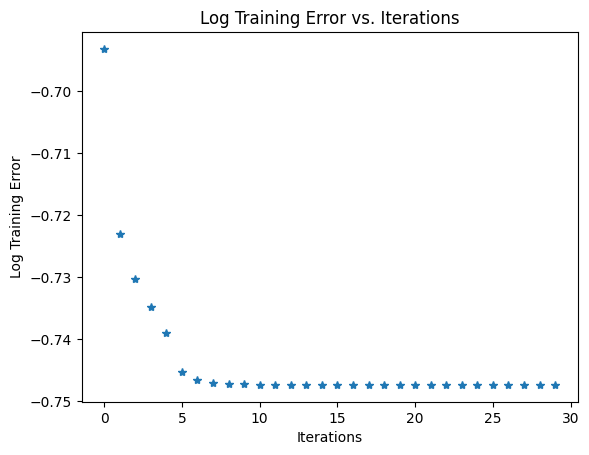

In [ ]:
#Inspect and Model the metrics and Coefficient and Visualize the log of the training error as a function of iteration. 
#The scatter plot visualizes the logarithm of the training error for all 10 iterations.

iterations = list(range(0,linearModel.summary.totalIterations + 1))
lossHistory = np.log(linearModel.summary.objectiveHistory)
plt.plot(iterations,lossHistory,'*')
plt.title('Log Training Error vs. Iterations')
plt.ylabel('Log Training Error')
plt.xlabel('Iterations')
# Intercept for the model
print("MAE: {0}".format(linearModel.summary.meanAbsoluteError))

/home/ubuntu/.local/lib/python3.10/site-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
/tmp/ipykernel_118059/837141695.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax1= sns.distplot(Y, hist=False, color="r", label="Actual Values")
/tmp/ipykernel_118059/837141695.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt yo

<Axes: ylabel='Density'>

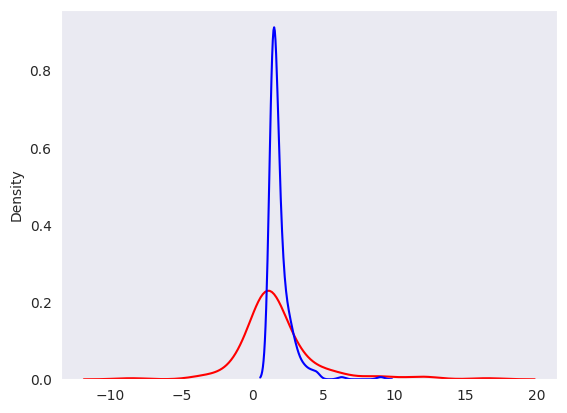

In [ ]:
# Use the method "predict" to predict an output on the polynomial features,
# then use the function "DistributionPlot" to display the distribution of the Predicted_Price vs the Weighted_Price from the test data

pred_results=linearModel.evaluate(test_data)
Y = pred_results.predictions.select('Score').toPandas()
_Y = pred_results.predictions.select("Predicted_Score").toPandas()
sns.set_style("dark")
ax1= sns.distplot(Y, hist=False, color="r", label="Actual Values")
sns.distplot(_Y, hist=False, color="b", label="Fitted Values" , ax=ax1)

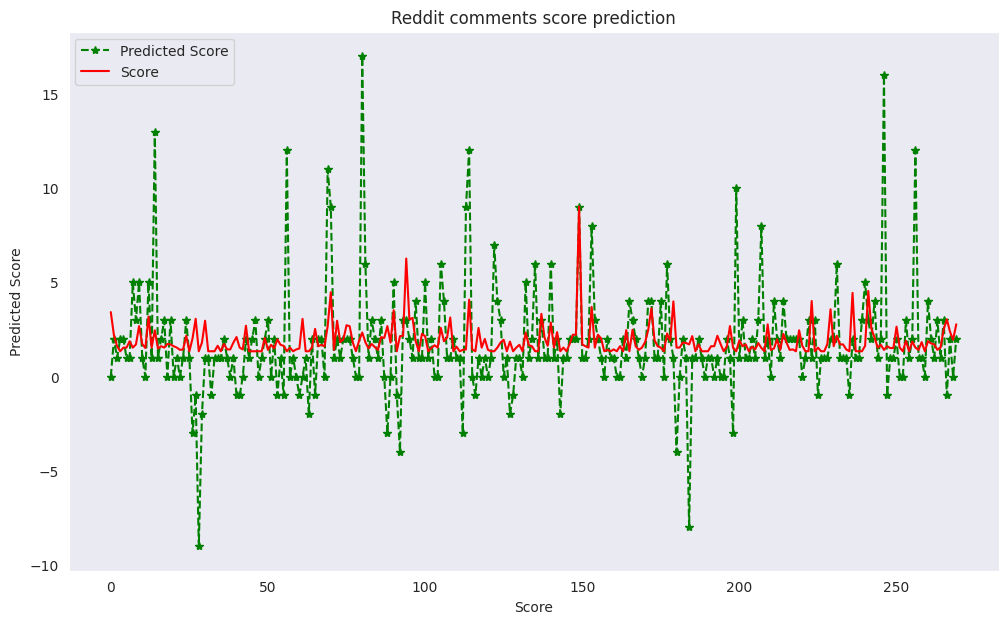

In [ ]:
#Plotting score vs predicted score using Matplotlib
plt.figure(figsize=(12,7))
plt.plot(Y, color='green', marker='*', linestyle='dashed', 
         label='Predicted Score')
plt.plot(_Y, color='red', label='Score')
plt.title('Reddit comments score prediction')
plt.xlabel('Score')
plt.ylabel('Predicted Score')
plt.legend()

In [ ]:
spark.stop() 
print(f'Execution time: {time.process_time() - start_time} seconds')

Execution time: 2.218044322 seconds
